## Earthquake parameters (2014 exercise)

Location: N 45.73, W 125.12

Depth: 2.0 km

Prelim Magnitude: M 9.0


In [1]:
#import globalETAS as gep
import numpy
import scipy
import math
import os
import sys
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
%matplotlib inline
%load_ext autoreload
%autoreload 2

#
import matplotlib.dates as mpd
from mpl_toolkits.basemap import Basemap as Basemap
#from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
#from geographiclib.geodesic import Geodesic as ggp
#
#
import ANSStools as atp
import contours2kml
import globalETAS as gep
import globalETAS_scripts as gesp
import eq_params as eqp
tzutc=pytz.timezone('UTC')
#
# define earthquake parameters.
eq_lat = 45.74
eq_lon = -125.12
eq_z = 2.0   #km
eq_m = 9.0
#
#ETAS resolution, etc. parameters:
n_processes = mpp.cpu_count()
n_contours=25
d_lat,d_lon = .1, .1
etas_range_factor=25
#etas_range_factor=5
etas_range_padding=2.25
#
mainshock = {'lat':eq_lat, 'lon':eq_lon, 'depth': eq_z, 'mag':eq_m}
#
# and let's have a go at replicating the rupture from the shakemap.
rupture_poly = [[-127.,49.5], [-125.5,46.], [-125., 40.], [-124.,40.], [-123., 47.], [-125.0, 49.75]]
if rupture_poly[-1]!=rupture_poly[0]: rupture_poly+=[rupture_poly[0]]



failed while loading urllib and/or urllib. maybe python 3.x?


## make a quick map that shows our rupture area, and maybe more stuff too.

In [2]:
# lons=[-132.5, -115.0], lats=[35.0, 53.]
lat_min = 35
lat_max=53
lon_min=-132.
lon_max = -115.
#
time_mainshock = dtm.datetime(2016,6,7, 8,30,0, tzinfo=pytz.timezone('US/Pacific'))

In [3]:
def angle_between_2d(v_seg1, v_seg2, deg_rad='rad'):
    #v0 = np.array(p0) - np.array(p1)
    #v1 = np.array(p2) - np.array(p1)
    #
    v_seg_1=numpy.array(v_seg1)
    if isinstance(v_seg_1[0], int) or isinstance(v_seg_1[0], float): v_seg_1 = [numpy.zeros(len(v_seg_1)),v_seg_1]
    v_seg_2=numpy.array(v_seg2)
    if isinstance(v_seg_2[0], int) or isinstance(v_seg_2[0], float): v_seg_2 = [numpy.zeros(len(v_seg_2)),v_seg_2]
    #
    v0 = v_seg_1[1]-v_seg_1[0]
    v1 = v_seg_2[1]-v_seg_2[0]
    #
    angle = numpy.math.atan2(numpy.linalg.det([v0,v1]), numpy.dot(v0,v1))
    #
    if deg_rad=='rad':
        return angle
    else:
        return numpy.degrees(angle)
#
def get_rotation_matrix(v_seg1, v_seg2):
    theta = angle_between_2d(v_seg1, v_seg2)
    #
    return numpy.array([[numpy.cos(theta), -numpy.sin(theta)], 
                         [numpy.sin(theta),  numpy.cos(theta)]])
#
#def move_and_rotate_coordinates(coords, )
#def vector_to_vector_rotation(vc1 = [1.,0.], vc2 = [0,1], ab=[1,1]):
#    # after doing some algebra and then translating to linear albebra, we get this matrix to transform one kn


#
def rotate_points(XY, theta=0., center=[0.,0.], deg=True):
    if deg: theta = numpy.radians(theta)
    center = numpy.array(center)
    #XY
    X,Y = (numpy.array(x) for x in zip(*(XY-center)))    
    #
    R = numpy.array([[numpy.cos(theta), -numpy.sin(theta)], 
                         [numpy.sin(theta),  numpy.cos(theta)]])
    #
    #XY_prime = numpy.dot(R, list(zip(*(XY-center))))
    X_prime, Y_prime = numpy.dot(R, (X,Y))
    #
    #XY_prime.shape=(int(XY_prime.size/2),2)
    X_prime += center[0]
    Y_prime += center[1]
    #
    return numpy.array(list(zip(X_prime, Y_prime)))
#
def draw_basic_map():
    plt.figure(0, figsize=(10,10))

    bm = Basemap(projection='cyl',llcrnrlat=lat_min,urcrnrlat=lat_max,\
                llcrnrlon=lon_min,urcrnrlon=lon_max, resolution='i')
    bm.drawcoastlines()
    bm.fillcontinents(color='coral',lake_color='aqua')
    # draw parallels and meridians.
    bm.drawparallels(numpy.arange(int(lat_min), int(lat_max), 2.))
    bm.drawmeridians(numpy.arange(int(lon_min), int(lon_max), 2.))
    bm.drawmapboundary(fill_color='aqua')
    plt.title("Cylindrical Projection")
    #
    #print('poly: ', rupture_poly)
    bm.plot(*zip(*rupture_poly), latlon=True, marker='', ls='-', lw=2.5)
    #
    return bm


## For the mainshock, use the Tohoku event. Copy the Tohoku sequence, rotate and translate to the Cascadia region. if we really want to be smart about it, we should probably also do a mirror transformation along the rupture axis, since the subduction is in the opposite direction.

In [4]:
#print('angle: ', angle_between_2d([[1.,1.], [2,1]], [[1,0.], [1,4]]))
#print(eqp.tohoku_ETAS_prams)

In [5]:
tpp = eqp.tohoku_ETAS_prams
# get mainshock:
tpp['lats']=[30.0, 43.]
mc=tpp['mc']
mc=4.0
tohoku_cat = atp.catfromANSS(lon=tpp['lons'], lat=tpp['lats'], minMag=mc, 
                             dates0=[dtm.datetime(2005,3,1, tzinfo=tzutc), dtm.datetime(2012,1,1,tzinfo=tzutc)],
                             Nmax=None, fout=None, rec_array=True)
local_cat = atp.catfromANSS(lon=[lon_min, lon_max], lat=[lat_min, lat_max], minMag=mc,
                            dates0=[dtm.datetime.now(tzutc)-dtm.timedelta(days=5*365), dtm.datetime.now(tzutc)],
                            Nmax=None, fout=None, rec_array=True)
#                            
max_m = max(tohoku_cat['mag'])
j_tohoku, tohoku_ms_rw = [[j,rw] for j,rw in enumerate(tohoku_cat) if rw['mag']==max_m][0]
print('tohoku_ms: ', j_tohoku, tohoku_ms_rw)
#
# translation vector from source to target location
dxdy = [mainshock['lon']-tohoku_ms_rw['lon'], mainshock['lat']-tohoku_ms_rw['lat']]
print('dxdy: ', dxdy)
#


data handle fetched...
 no file.
data handle fetched...
 no file.
tohoku_ms:  2792 (datetime.datetime(2011, 3, 11, 5, 46, 24, 120000), 38.297, 142.373, 9.1, 29.0, 734207.2405569444)
dxdy:  [-267.49299999999999, 7.4430000000000049]


tohoku time_delta:  1915 days, 10:36:36


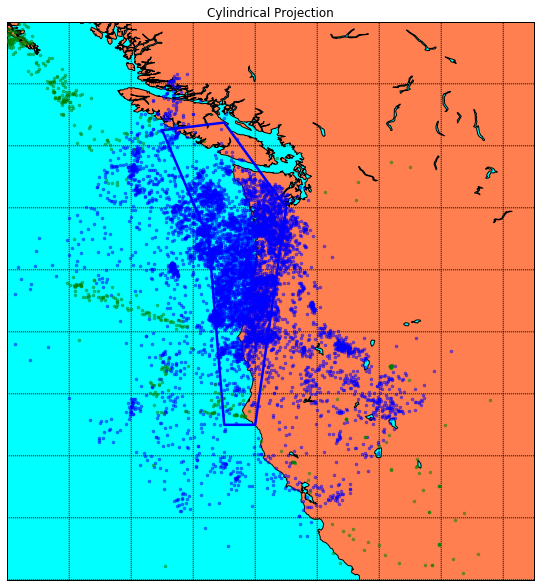

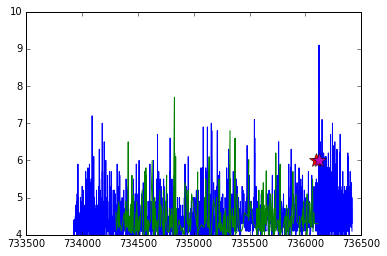

In [6]:
tohoku_cat_prime = tohoku_cat.copy()
local_cat_prime = local_cat.copy()
#
theta = 50
#
XY_prime = rotate_points(numpy.array(list(zip( (tohoku_cat_prime['lon']), (tohoku_cat_prime['lat'])))), theta, center=[tohoku_ms_rw['lon'], tohoku_ms_rw['lat']])
XY_prime += dxdy
#
# and a symmetry operation:
do_symm_opp=False
if do_symm_opp:
    ms_center = [mainshock['lon'], mainshock['lat']]
    XY_prime-=ms_center
    XY_prime = rotate_points(XY_prime, -10, center=[0,0])
    #print('xy: ', XY_prime[0:5])
    Ms = [[-1., 0], [0.,1.]]
    XY_prime = numpy.array([numpy.dot(Ms, rw) for rw in XY_prime])
    XY_prime = rotate_points(XY_prime, 10, center=(0,0)) + ms_center
    #XY_prime = numpy.dot(Ms,)+ms_center
#
tohoku_cat_prime['lon'], tohoku_cat_prime['lat'] = numpy.array(list(zip(*XY_prime)))
# now, get the tohoku datetime. move up all the tohoku events to (around) the 7 june cascadia event time.
# let's also pull some events from today around the region and construct a composite catalog.
t_tohoku = dtm.datetime(*(x for x in tohoku_ms_rw['event_date'].tolist().timetuple()[0:6]), tzinfo=tzutc)
tohoku_time_delta = time_mainshock-t_tohoku
print('tohoku time_delta: ', tohoku_time_delta)
for j,dt in enumerate(tohoku_cat_prime['event_date']):
    tohoku_cat_prime['event_date'][j] = numpy.datetime64(dt.tolist() + tohoku_time_delta)
    tohoku_cat_prime['event_date_float'][j] = mpd.date2num(dt.tolist() + tohoku_time_delta)
#
# and bump up the local catalog to the event date.
local_time_delta = time_mainshock-dtm.datetime.now(tzutc)
#print('ltd: ', local_time_delta.days)
for j,dt in enumerate(local_cat_prime['event_date']):
    local_cat_prime['event_date'][j] = numpy.datetime64(dt.tolist() + local_time_delta)
    local_cat_prime['event_date_float'][j] = mpd.date2num(dt.tolist() + local_time_delta)
#
bm = draw_basic_map()
bm.plot(tohoku_cat_prime['lon'], tohoku_cat_prime['lat'], marker='.', color='b', ls='', alpha=.5,zorder=6)
bm.plot(local_cat_prime['lon'], local_cat_prime['lat'], marker='.', color='g', ls='', alpha=.5, zorder=7)
#
# Take a look at what we've got so far:
#print('dtype', tohoku_cat_prime.dtype.names)
plt.figure()
plt.plot(tohoku_cat_prime['event_date_float'], tohoku_cat_prime['mag'])
plt.plot(local_cat_prime['event_date_float'], local_cat_prime['mag'])
plt.plot([mpd.date2num(dtm.datetime.now(tzutc))], [6], marker='*', color='r', ls='', ms=15, zorder=6)
plt.plot([mpd.date2num(time_mainshock)], [6], marker='*', color='m', ls='', ms=15, zorder=6)
#plt.plot(tohoku_cat_prime['event_date'], tohoku_cat_prime['mag'])
#plt.plot(local_cat_prime['event_date'], local_cat_prime['mag'])

In [7]:
#

In [8]:
# now, make an ETAS-ready catalog:
# TODO: set lats=[], lons=[] to get better definition of map boundaries.
# now, combine the Tohoku and Local catalogs and process for ETAS.
combined_catalog = numpy.core.records.fromarrays(zip(*tohoku_cat_prime.tolist() + local_cat_prime.tolist()), dtype=local_cat_prime.dtype)
combined_catalog.sort(order='event_date_float')
etas_cat = gep.make_ETAS_catalog_mpp(incat=combined_catalog)    # and otherwise, the defaults should be ok.
#
print('ETAS catalog processed.')

etas_prams:  {'b1': 1.0, 'do_recarray': True, 'lats': [32.0, 38.0], 'q': 1.5, 'date_range': ['1990-1-1', None], 'D_fract': 1.5, 'fit_factor': 1.5, 'd_tau': 2.28, 'b2': 1.5, 'mc': 2.5, 'p': 1.1, 'lons': [-117.0, -114.0], 'dmstar': 1.0, 'd_lambda': 1.76, 'incat': None}


/home/myoder/Documents/Research/Yoder/globalETAS/globalETAS.py:1255: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if incat==None or (hasattr(incat, '__len__') and len(incat)==0):
/home/myoder/Documents/Research/Yoder/globalETAS/globalETAS.py:1320: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if incat==None:
/home/myoder/Documents/Research/Yoder/globalETAS/globalETAS.py:1349: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if incat==None or (hasattr(incat, '__len__') and len(incat)==0):
/home/myoder/Documents/Research/Yoder/globalETAS/globalETAS.py:1320: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if incat==None:
/home/myoder/Documents/Research/Yoder/globalETAS/globalETAS.py:1320: FutureWarning: comparison to `None` will result in an elementwise object comparison in th

R:  <multiprocessing.pool.ApplyResult object at 0x7f56c8656ef0>


/home/myoder/Documents/Research/Yoder/globalETAS/globalETAS.py:1603: RuntimeWarning: divide by zero encountered in true_divide
  cov = numpy.dot(numpy.array(list(zip(*cat_prime))),numpy.array(cat_prime))/n_dof
/home/myoder/Documents/Research/Yoder/globalETAS/globalETAS.py:1603: RuntimeWarning: divide by zero encountered in true_divide
  cov = numpy.dot(numpy.array(list(zip(*cat_prime))),numpy.array(cat_prime))/n_dof
/home/myoder/Documents/Research/Yoder/globalETAS/globalETAS.py:1603: RuntimeWarning: divide by zero encountered in true_divide
  cov = numpy.dot(numpy.array(list(zip(*cat_prime))),numpy.array(cat_prime))/n_dof
/home/myoder/Documents/Research/Yoder/globalETAS/globalETAS.py:1603: RuntimeWarning: divide by zero encountered in true_divide
  cov = numpy.dot(numpy.array(list(zip(*cat_prime))),numpy.array(cat_prime))/n_dof
/home/myoder/Documents/Research/Yoder/globalETAS/globalETAS.py:1603: RuntimeWarning: divide by zero encountered in true_divide
  cov = numpy.dot(numpy.array(lis

R:  <multiprocessing.pool.ApplyResult object at 0x7f56c8656f98>
R:  <multiprocessing.pool.ApplyResult object at 0x7f56c8629080>
R:  <multiprocessing.pool.ApplyResult object at 0x7f56c8629128>
R:  <multiprocessing.pool.ApplyResult object at 0x7f56c86291d0>
R:  <multiprocessing.pool.ApplyResult object at 0x7f56c8629278>
R:  <multiprocessing.pool.ApplyResult object at 0x7f56c8629320>
results fetched.
ETAS catalog processed.


In [9]:
print(tohoku_ms_rw, tohoku_ms_rw.dtype.names)
print(type(tohoku_ms_rw['event_date'].tolist()))
print(time_mainshock)

(datetime.datetime(2011, 3, 11, 5, 46, 24, 120000), 38.297, 142.373, 9.1, 29.0, 734207.2405569444) ('event_date', 'lat', 'lon', 'mag', 'depth', 'event_date_float')
<class 'datetime.datetime'>
2016-06-07 08:30:00-07:53


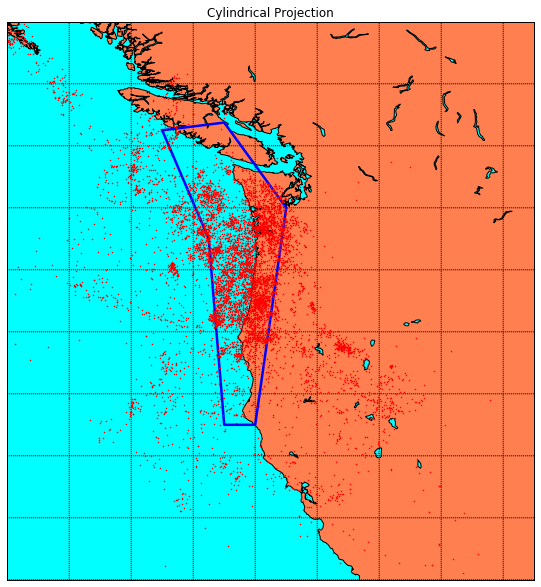

In [ ]:
bm = draw_basic_map()
bm.plot(etas_cat['lon'], etas_cat['lat'], ls='', marker='.', ms=2, color='r')
    #
#draw_map()
    #
    

Now, load up an ETAS object. maybe we can develop some sample seed catalogs from which to base earthquake orientation, and maybe create some examples with Nepal-like not co-located clustering. maybe grab the Nepal sequence and rotate/scale it to the Cascadia fault?

In [ ]:
# now, generate ETAS from our new catalog
# resolution and other parameters are set in opening cell.
#
t_now = time_mainshock+dtm.timedelta(hours=1)
#
#etas = gep.ETAS_mpp_handler_xyz(n_processes = n_processes, *args, **kwargs)
# catalog=None, lats=None, lons=None, mc=2.5, mc_etas=None, d_lon=.1, d_lat=.1, bin_lon0=0., bin_lat0=0., 
#       etas_range_factor=10.0, etas_range_padding=.25, etas_fit_factor=1.0, t_0=dtm.datetime(1990,1,1, tzinfo=tz_utc),
#       t_now=dtm.datetime.now(tzutc), transform_type='equal_area', transform_ratio_max=2.5, cat_len=5.*365., 
#      calc_etas=True, n_contours=15, etas_cat_range=None, etas_xyz_range=None, p_cat=1.1, q_cat=1.5, p_etas=None,**kwargs):
#
# there may be a problem with pickling the catalog objects when we provide a catalog.
# TODO: set t_now to define the forcast date. we'll want to make a list of t_now and create aftershock export products
# for each t_now.
etas = gep.ETAS_mpp_handler_xyz(n_processes = n_processes, t_now=t_now, catalog=etas_cat, lons=[lon_min, lon_max], lats=[lat_min, lat_max], mc=None,
                               d_lat=d_lat, d_lon=d_lon, etas_range_factor=etas_range_factor,
                                etas_range_padding=etas_range_padding, etas_fit_factor=1.0,
                                n_contours=n_contours)
#

begin globalETAS.__init()__
Overriding t0 for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-06-09 09:30:00-07:53
ETAS over etas_cat_range/xyz_range:  ([0, 8177], None)
make_etas():
etas_mpp worker xyz_range:  [0, 3825]
begin globalETAS.__init()__
Overriding t0 for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-06-09 09:30:00-07:53
ETAS over etas_cat_range/xyz_range:  ([0, 8177], [0, 3825])
etas_mpp worker xyz_range:  [3825, 7650]
begin globalETAS.__init()__
Overriding t0 for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-06-09 09:30:00-07:53
ETAS over etas_cat_range/xyz_range:  ([0, 8177], [3825, 7650])
etas_mpp worker xyz_range:  [7650, 11475]
begin globalETAS.__init()__
Overriding t0 for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-06-09 09:30:00-07:53
ETAS over etas_cat_range/xyz_range:  ([0, 8177], [7650, 11475])
etas_mpp worker xyz_range:  [114

/home/myoder/Documents/Research/Yoder/globalETAS/globalETAS.py:155: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if mc   == None and not (catalog == None or len(catalog) == 0): mc = min(catalog['mag'])
/home/myoder/Documents/Research/Yoder/globalETAS/globalETAS.py:210: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if catalog==None:


ETAS over etas_cat_range/xyz_range:  ([0, 8177], [19125, 22950])
etas_mpp worker xyz_range:  [22950, 26775]
begin globalETAS.__init()__
Overriding t0 for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-06-09 09:30:00-07:53
ETAS over etas_cat_range/xyz_range:  ([0, 8177], [22950, 26775])
etas_mpp worker xyz_range:  [26775, 30600]
begin globalETAS.__init()__
Overriding t0 for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-06-09 09:30:00-07:53
ETAS over etas_cat_range/xyz_range:  ([0, 8177], [26775, 30600])
begin make_etas_rtree()
begin make_etas_rtree()
begin make_etas_rtree()
begin make_etas_rtree()
begin make_etas_rtree()
begin make_etas_rtree()
begin make_etas_rtree()
begin make_etas_rtree()
now gather sub-arrays...
len(local_lattice_dict):  3825
len(local_lattice_dict):  3825
len(local_lattice_dict):  3825
len(local_lattice_dict):  3825
len(local_lattice_dict):  3825
len(local_lattice_dict):  3825
len(local_lattice_di

In [ ]:
fignum=0
plt.figure()
figsize=(10,10)
color_map='hot'
bm2=etas.make_etas_contour_map(n_contours=n_contours, fignum=fignum, fig_size=figsize, kml_contours_bottom=0., 
                           kml_contours_top=1.0, alpha=.6, map_resolution='i', map_projection='cyl', map_cmap=color_map)
#                           ,
#                           contour_fig_file=png_file, contour_kml_file=kml_file, alpha_kml=.5, refresh_etas=False)
etas.cm.plot(*zip(*rupture_poly), latlon=True, marker='', ls='-', lw=2.5)  

### ... and we should be able to use the globalETAS scripts to produce a set of ETAS, including export files.

In [ ]:
# etas_outputs(n_processes = None, output_path='etas_outputs/', kml_file='etas_kml.kml', png_file=None,
# xyz_file=None, fignum=0, color_map='jet', *args, **kwargs)
time_deltas = [-dtm.timedelta(days=10), -dtm.timedelta(days=1), dtm.timedelta(hours=2), dtm.timedelta(hours=8), dtm.timedelta(hours=16),
               dtm.timedelta(days=1), dtm.timedelta(hours=36), dtm.timedelta(days=2), dtm.timedelta(days=2,hours=12),
               dtm.timedelta(days=3), dtm.timedelta(days=3,hours=12), dtm.timedelta(days=4)]

output_path='%s/Dropbox/Research/CascadiaRising2016/outputs_hires' % os.getenv('HOME')
#etas = gep.ETAS_mpp_handler_xyz(n_processes = n_processes, t_now=t_now, catalog=etas_cat, lons=[lon_min, lon_max], lats=[lat_min, lat_max], mc=None,
#                               d_lat=d_lat, d_lon=d_lon, etas_range_factor=etas_range_factor,
#                                etas_range_padding=etas_range_padding, etas_fit_factor=1.0,
#                                n_contours=n_contours)
kwds = {'n_processes':n_processes, 't_now':t_now, 'catalog':etas_cat, 'lons':[lon_min, lon_max], 'lats':[lat_min, lat_max],
        'mc':None, 'd_lat':d_lat, 'd_lon':d_lon, 'etas_range_factor':etas_range_factor, 
        'etas_range_padding':etas_range_padding, 'etas_fit_factor':1.0, 'n_contours':n_contours}
#
for td in time_deltas:
    t_now = time_mainshock+td
    #
    kml_file = 'Cascadia_Rising_Exercise_2016_etas_%s_kml.kml' % str(t_now)
    kwds.update({'t_now':t_now})
    #
    etas_output = gesp.etas_outputs(output_path=output_path, kml_file=kml_file, png_file=None,
                                   xyz_file=None, fignum=0, color_map='jet', **kwds)